In [2]:
import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
import numpy as np
from PIL import Image
import glob

from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET # full size version 173.6 MB
from model import U2NETP # small version u2net 4.7 MB

from skimage.filters import gaussian
import cv2
import matplotlib.pyplot as plt
import random


def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def save_output(image_name,pred,d_dir):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    imo.save(d_dir+imidx+'_mask.png')
    
    
def save_output_1(image_name,pred,d_dir,sigma=2,alpha=0.5):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    image = io.imread(image_name)
    pd = transform.resize(predict_np,image.shape[0:2],order=2)
    pd = pd/(np.amax(pd)+1e-8)*255
    pd = pd[:,:,np.newaxis]

    print(image.shape)
    print(pd.shape)

    ## fuse the orignal portrait image and the portraits into one composite image
    ## 1. use gaussian filter to blur the orginal image
    sigma=sigma
    image = gaussian(image, sigma=sigma, preserve_range=True)

    ## 2. fuse these orignal image and the portrait with certain weight: alpha
    alpha = alpha
    im_comp = image*alpha+pd*(1-alpha)

    print(im_comp.shape)


    img_name = image_name.split(os.sep)[-1]
    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]
    io.imsave(d_dir+'/'+imidx+'_sigma_' + str(sigma) + '_alpha_' + str(alpha) + '_composite.png',im_comp)

def main():
    image_name = 'input/a.jpeg'
    img = cv2.imread(image_name) 
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img)


    model_name='u2net'#u2netp
    if(model_name=='u2net'):
        print("...load U2NET---173.6 MB")
        net = U2NET(3,1)
    elif(model_name=='u2netp'):
        print("...load U2NEP---4.7 MB")
        net = U2NETP(3,1)

    image_dir = os.path.join(os.getcwd(), 'test_data', 'test_images')
    prediction_dir = 'input/' #os.path.join(os.getcwd(), 'test_data', model_name + '_results' + os.sep)
    model_dir = os.path.join(os.getcwd(),'saved_models', model_name, model_name + '.pth')

    img_name_list = [image_name] #glob.glob(image_dir + os.sep + '*')
    print(img_name_list)

    # --------- 2. dataloader ---------
    #1. dataloader
    test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(320),
                                                                      ToTensorLab(flag=0)])
                                        )
    test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

    # --------- 3. model define ---------

    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_dir))
        net.cuda()
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()

    # --------- 4. inference for each image ---------
    for i_test, data_test in enumerate(test_salobj_dataloader):

        print("inferencing:",img_name_list[i_test].split(os.sep)[-1])

        inputs_test = data_test['image']
        inputs_test = inputs_test.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_test = Variable(inputs_test.cuda())
        else:
            inputs_test = Variable(inputs_test)

        d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

        # normalization
        pred = d1[:,0,:,:]
        pred = normPRED(pred)

        # save results to test_results folder
        if not os.path.exists(prediction_dir):
            os.makedirs(prediction_dir, exist_ok=True)
        save_output(img_name_list[i_test],pred,prediction_dir)

        del d1,d2,d3,d4,d5,d6,d7

    img = cv2.imread(image_name) 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    bg = random.choice(glob.glob('patterns/*'))

    bg = cv2.imread(bg) 
    bg = cv2.cvtColor(bg, cv2.COLOR_RGB2BGR)
    bg = cv2.resize(bg, (img.shape[1], img.shape[0]))
    img_mask = cv2.imread('input/a_mask.png')

    transparent = cv2.bitwise_and(img, img, mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY))

    transparent = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
    transparent[:,:,0:3] = img
    transparent[:, :, 3] = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

if __name__ == "__main__":
    main()

/home/vatsal/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


...load U2NET---173.6 MB
['input/a.jpeg']
inferencing: a.jpeg


RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

In [1]:
import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
# import torch.optim as optim

import numpy as np
from PIL import Image
import glob

from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET # full size version 173.6 MB
from model import U2NETP # small version u2net 4.7 MB

/home/vatsal/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


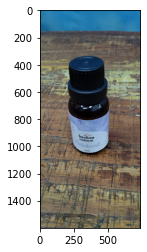

In [2]:
import numpy as np
from skimage.filters import gaussian
import cv2
import matplotlib.pyplot as plt

# reads image 'opencv-logo.png' as grayscale
image_name = 'input/a.jpeg'
img = cv2.imread(image_name) 
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [3]:
 # --------- 1. get image path and name ---------
model_name='u2net'#u2netp
if(model_name=='u2net'):
    print("...load U2NET---173.6 MB")
    net = U2NET(3,1)
elif(model_name=='u2netp'):
    print("...load U2NEP---4.7 MB")
    net = U2NETP(3,1)

...load U2NET---173.6 MB


In [4]:


# normalize the predicted SOD probability map
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def save_output(image_name,pred,d_dir):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    imo.save(d_dir+imidx+'_mask.png')
    
    
def save_output_1(image_name,pred,d_dir,sigma=2,alpha=0.5):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    image = io.imread(image_name)
    pd = transform.resize(predict_np,image.shape[0:2],order=2)
    pd = pd/(np.amax(pd)+1e-8)*255
    pd = pd[:,:,np.newaxis]

    print(image.shape)
    print(pd.shape)

    ## fuse the orignal portrait image and the portraits into one composite image
    ## 1. use gaussian filter to blur the orginal image
    sigma=sigma
    image = gaussian(image, sigma=sigma, preserve_range=True)

    ## 2. fuse these orignal image and the portrait with certain weight: alpha
    alpha = alpha
    im_comp = image*alpha+pd*(1-alpha)

    print(im_comp.shape)


    img_name = image_name.split(os.sep)[-1]
    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]
    io.imsave(d_dir+'/'+imidx+'_sigma_' + str(sigma) + '_alpha_' + str(alpha) + '_composite.png',im_comp)

def main():
    image_dir = os.path.join(os.getcwd(), 'test_data', 'test_images')
    prediction_dir = 'input/' #os.path.join(os.getcwd(), 'test_data', model_name + '_results' + os.sep)
    model_dir = os.path.join(os.getcwd(), 'saved_models', model_name, model_name + '.pth')

    img_name_list = [image_name] #glob.glob(image_dir + os.sep + '*')
    print(img_name_list)

    # --------- 2. dataloader ---------
    #1. dataloader
    test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(320),
                                                                      ToTensorLab(flag=0)])
                                        )
    test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

    # --------- 3. model define ---------

    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_dir))
        net.cuda()
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()

    # --------- 4. inference for each image ---------
    for i_test, data_test in enumerate(test_salobj_dataloader):

        print("inferencing:",img_name_list[i_test].split(os.sep)[-1])

        inputs_test = data_test['image']
        inputs_test = inputs_test.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_test = Variable(inputs_test.cuda())
        else:
            inputs_test = Variable(inputs_test)

        d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

        # normalization
        pred = d1[:,0,:,:]
        pred = normPRED(pred)

        # save results to test_results folder
        if not os.path.exists(prediction_dir):
            os.makedirs(prediction_dir, exist_ok=True)
        save_output(img_name_list[i_test],pred,prediction_dir)

        del d1,d2,d3,d4,d5,d6,d7

if __name__ == "__main__":
    main()

['input/a.jpeg']
inferencing: a.jpeg


RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

(1600, 738, 3) (1600, 738, 3)


<AxesSubplot:>

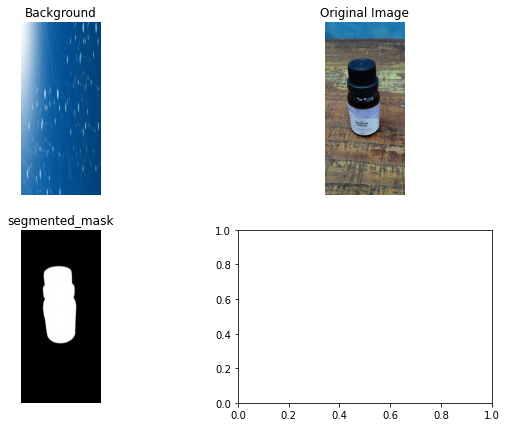

In [5]:
import cv2
import numpy as np
import glob
import random 
img = cv2.imread(image_name) 
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
bg = random.choice(glob.glob('patterns/*'))

bg = cv2.imread(bg) 
bg = cv2.cvtColor(bg, cv2.COLOR_RGB2BGR)
bg = cv2.resize(bg, (img.shape[1], img.shape[0]))
img_mask = cv2.imread('input/a_mask.png')#image_name.split('.')[0]+'_mask.png')


fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)

plt.imshow(bg)
plt.axis('off')
plt.title("Background")

fig.add_subplot(2, 2, 2)
  
# showing image
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 3rd position
fig.add_subplot(2, 2, 3)
  
# showing image
plt.imshow(img_mask)
plt.axis('off')
plt.title("segmented_mask")

alpha = 0.5
beta = (1.0 - alpha)
print (bg.shape, img.shape)
res = cv2.addWeighted(bg, alpha, img, beta, 0.0)


fig.add_subplot(2, 2, 4)
  
# showing image
# plt.imshow(res)
# plt.axis('off')
# plt.title("generated image")

# 40% -> P1
# P2

error: OpenCV(4.6.0) /io/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


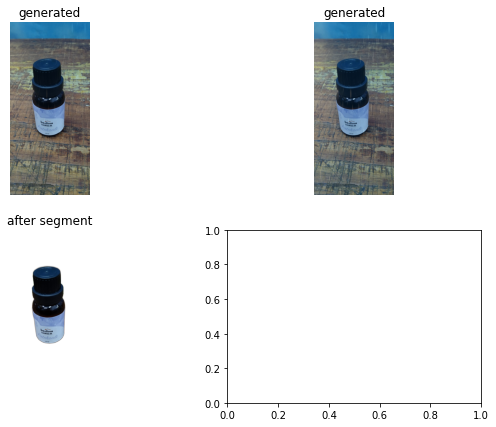

In [11]:
from PIL import Image as im

transparent = cv2.bitwise_and(img, img, mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY))

transparent = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
transparent[:,:,0:3] = img
transparent[:, :, 3] = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
transparent.shape
image = im.fromarray(transparent)
image.save('transparent.png')